In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import  metrics

In [ ]:
#'loan_2015_ready_RF.csv'：impute missing values

In [150]:
df = pd.read_csv('loan_2015_ready.csv')
df.shape

(283165, 119)

In [151]:
select_feature = ['totalilhighcreditlimit', 'allutil', 'numtl120dpd2m', 'mthssincerecentbc', 'inqlast12m', 'mortacc', 'numtl30dpd', 'openacc6m', 'pubrecbankruptcies', 'mthssincerecentinq', 'numrevaccts', 'numactvrevtl', 'dti', 'mthssincelastdelinq', 'mthssincelastmajorderog', 'openacc', 'delinqamnt', 'mthssincerecentbcdlq', 'pcttlnvrdlq', 'accopenpast24mths', 'annualincjoint', 'loanamnt', 'mosinrcnttl', 'openrv12m', 'accnowdelinq', 'totalbalil', 'mthssincercntil', 'collections12mthsexmed', 'avgcurbal', 'delinq2yrs', 'dtijoint', 'numoprevtl', 'annualinc', 'numrevtlbalgt0', 'mosinoldilacct', 'openil12m', 'mosinrcntrevtlop', 'taxliens', 'totalrevhilim', 'openactil', 'numacctsever120pd', 'percentbcgt75', 'totalbclimit', 'maxbalbc', 'openrv24m', 'totalacc', 'mthssincelastrecord', 'ficorangehigh', 'numtl90gdpd24m', 'numsats', 'revolbal', 'ficorangelow', 'totcollamt', 'totalbalexmort', 'chargeoffwithin12mths', 'totalcutl', 'inqfi', 'mosinoldrevtlop', 'numtloppast12m', 'bcutil', 'numiltl', 'installment', 'inqlast6mths', 'pubrec', 'tothicredlim', 'totcurbal', 'numbcsats', 'mthssincerecentrevoldelinq', 'ilutil', 'numactvbctl', 'openil24m', 'numbctl', 'bcopentobuy', 'earliestcrline_month', 'emplength', 'intrate', 'revolutil', 'grade', 'subgrade', 'zipcode', 'zipcode_freq', 'addrstate_freq', 'emptitle_freq', 'verificationstatusjoint_Not Verified', 'homeownership_ANY', 'homeownership_MORTGAGE', 'homeownership_OWN', 'homeownership_RENT', 'verificationstatus_Not Verified', 'verificationstatus_Source Verified', 'verificationstatus_Verified', 'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding', 'initialliststatus_f', 'initialliststatus_w']
feat = select_feature
len(feat)

107

In [152]:
df_train = df.query("train_flg==1")
df_test = df.query("train_flg==0")
df_train.shape,df_test.shape

((252828, 119), (30337, 119))

### missing values handling 

In [153]:
# remove the features which has more than 70% missing value
major_missing_feature =[]
minor_missing_feature =[]
for col in feat:
    if df[col].isnull().sum() >= (df[col].shape[0])*.7:
        major_missing_feature.append(col)
    else:
        if df[col].isnull().sum() > 0:
            minor_missing_feature.append(col)
print('major_missing_feature:\n',major_missing_feature)
print('minor_missing_feature:\n',minor_missing_feature)
feat = list(set(feat)-set(major_missing_feature))
len(feat)

major_missing_feature:
 ['allutil', 'inqlast12m', 'openacc6m', 'mthssincerecentbcdlq', 'annualincjoint', 'openrv12m', 'totalbalil', 'mthssincercntil', 'dtijoint', 'openil12m', 'openactil', 'maxbalbc', 'openrv24m', 'mthssincelastrecord', 'totalcutl', 'inqfi', 'ilutil', 'openil24m']
minor_missing_feature:
 ['numtl120dpd2m', 'mthssincerecentbc', 'mthssincerecentinq', 'numrevaccts', 'dti', 'mthssincelastdelinq', 'mthssincelastmajorderog', 'mosinoldilacct', 'percentbcgt75', 'bcutil', 'mthssincerecentrevoldelinq', 'bcopentobuy', 'revolutil', 'emptitle_freq']


89

In [154]:
df[minor_missing_feature].isnull().sum()

numtl120dpd2m                  14235
mthssincerecentbc               2726
mthssincerecentinq             31251
numrevaccts                        1
dti                                2
mthssincelastdelinq           135888
mthssincelastmajorderog       197636
mosinoldilacct                  9961
percentbcgt75                   3087
bcutil                          3029
mthssincerecentrevoldelinq    179660
bcopentobuy                     2834
revolutil                        126
emptitle_freq                  19019
dtype: int64

In [155]:
df['emptitle_freq'].replace(np.NaN, 0, inplace=True)

In [156]:
# mthssincerecentrevoldelinq: Months since most recent revolving delinquency.
df['mthssincerecentrevoldelinq'].replace(np.NaN, 99999, inplace=True)
df['mthssincerecentrevoldelinq'].isnull().sum()

0

In [157]:
df[['bcopentobuy','totalbclimit','bcutil','revolutil', 'revolbal','totalrevhilim']][:5]
#revolbal:Total credit revolving balance
#totalrevhilim: Total revolving high credit/credit limit
#bcopentobuy: credit available,Total open to buy on revolving bankcards.
#totalbclimit: Total bankcard high credit/credit limit
#revolutil=100*revolbal/totalrevhilim
#bcutil = 100-100*bcopentobuy/totalbclimit


,bcopentobuy,totalbclimit,bcutil,revolutil,revolbal,totalrevhilim
0,57830.0,79300.0,27.1,19.2,21470.0,111800.0
1,1506.0,2400.0,37.2,29.7,2765.0,9300.0
2,844.0,9400.0,91.0,68.4,8822.0,12900.0
3,0.0,31500.0,102.9,84.5,87329.0,94200.0
4,7940.0,34500.0,77.0,67.2,37828.0,56300.0


In [158]:
#revolutil:%Revolving line utilization rate:the amount of credit the borrower is using relative to all available revolving credit.
#102 of totalrevhilim are 0, so impute revolutil with 0
df['revolutil'].replace(np.NaN, 0, inplace=True)
df['revolutil'].isnull().sum()

0

In [159]:
#totalbclimit=0 lead to bcutil=nan
df['bcutil'].replace(np.NaN, 0, inplace=True)
df['bcutil'].isnull().sum()

0

In [160]:
#totalbclimit=0 lead to bcutil=nan, no revolving account
df['bcopentobuy'].replace(np.NaN, 0, inplace=True)
df['bcopentobuy'].isnull().sum()

0

In [161]:
#'totalbclimit'=0 lead to 'percentbcgt75'=nan, so impute 0, no bankcard
df['percentbcgt75'].replace(np.NaN, 0, inplace=True)
df['percentbcgt75'].isnull().sum()

0

In [162]:
#mthssincelastmajorderog: Months since most recent 90-day or worse rating
df['mthssincelastmajorderog'].replace(np.NaN, 99999, inplace=True)
df['mthssincelastmajorderog'].isnull().sum()

0

In [163]:
df['mthssincelastdelinq'].replace(np.NaN, 99999, inplace=True)
df['mthssincelastdelinq'].isnull().sum()

0

In [164]:
df['mthssincerecentinq'].replace(np.NaN, 99999, inplace=True)
df['mthssincerecentinq'].isnull().sum()

0

In [165]:
#mthssincerecentbc:Months since most recent bankcard account opened.
df['mthssincerecentbc'].replace(np.NaN, 99999, inplace=True)
df['mthssincerecentbc'].isnull().sum()

0

In [166]:
#mosinoldilacct: Months since oldest bank installment account opened
df['mosinoldilacct'].replace(np.NaN, 99999, inplace=True)
df['mosinoldilacct'].isnull().sum()

0

In [167]:
#numtl120dpd2m: Number of accounts currently 120 days past due (updated in past 2 months)
#numtl120dpd2m=nan probably means no any loan account, so impute 0
df['numtl120dpd2m'].replace(np.NaN, 0, inplace=True)
df['numtl120dpd2m'].isnull().sum()

0

In [168]:
df[minor_missing_feature].isnull().sum()

numtl120dpd2m                 0
mthssincerecentbc             0
mthssincerecentinq            0
numrevaccts                   1
dti                           2
mthssincelastdelinq           0
mthssincelastmajorderog       0
mosinoldilacct                0
percentbcgt75                 0
bcutil                        0
mthssincerecentrevoldelinq    0
bcopentobuy                   0
revolutil                     0
emptitle_freq                 0
dtype: int64

In [169]:
print(feat)

['mosinrcntrevtlop', 'purpose_other', 'emplength', 'numtl30dpd', 'initialliststatus_f', 'installment', 'addrstate_freq', 'numrevtlbalgt0', 'revolbal', 'delinq2yrs', 'grade', 'purpose_vacation', 'purpose_educational', 'mosinoldrevtlop', 'purpose_car', 'verificationstatus_Not Verified', 'dti', 'accnowdelinq', 'totalbclimit', 'annualinc', 'ficorangehigh', 'earliestcrline_month', 'pcttlnvrdlq', 'percentbcgt75', 'mosinoldilacct', 'subgrade', 'totcollamt', 'mthssincerecentbc', 'mthssincelastmajorderog', 'homeownership_OWN', 'purpose_debt_consolidation', 'openacc', 'numsats', 'purpose_major_purchase', 'numactvrevtl', 'mthssincelastdelinq', 'purpose_credit_card', 'numiltl', 'numactvbctl', 'tothicredlim', 'totalrevhilim', 'numtloppast12m', 'totalacc', 'mortacc', 'mosinrcnttl', 'inqlast6mths', 'totcurbal', 'avgcurbal', 'homeownership_RENT', 'chargeoffwithin12mths', 'purpose_wedding', 'purpose_home_improvement', 'homeownership_ANY', 'intrate', 'revolutil', 'initialliststatus_w', 'loanamnt', 'pubr

In [170]:
# update feat for random forest
feat = ['mosinrcntrevtlop', 'purpose_other', 'emplength', 'numtl30dpd', 'initialliststatus_f', 'installment', 'addrstate_freq', 'numrevtlbalgt0', 'revolbal', 'delinq2yrs', 'grade', 'purpose_vacation', 'purpose_educational', 'mosinoldrevtlop', 'purpose_car', 'verificationstatus_Not Verified', 'dti', 'accnowdelinq', 'totalbclimit', 'annualinc', 'ficorangehigh', 'earliestcrline_month', 'pcttlnvrdlq', 'percentbcgt75', 'mosinoldilacct', 'subgrade', 'totcollamt', 'mthssincerecentbc', 'mthssincelastmajorderog', 'homeownership_OWN', 'purpose_debt_consolidation', 'openacc', 'numsats', 'purpose_major_purchase', 'numactvrevtl', 'mthssincelastdelinq', 'purpose_credit_card', 'numiltl', 'numactvbctl', 'tothicredlim', 'totalrevhilim', 'numtloppast12m', 'totalacc', 'mortacc', 'mosinrcnttl', 'inqlast6mths', 'totcurbal', 'avgcurbal', 'homeownership_RENT', 'chargeoffwithin12mths', 'purpose_wedding', 'purpose_home_improvement', 'homeownership_ANY', 'intrate', 'revolutil', 'initialliststatus_w', 'loanamnt', 'pubrecbankruptcies', 'zipcode_freq', 'ficorangelow', 'verificationstatusjoint_Not Verified', 'purpose_small_business', 'homeownership_MORTGAGE', 'numoprevtl', 'purpose_renewable_energy', 'numbcsats', 'emptitle_freq', 'collections12mthsexmed', 'bcopentobuy', 'numtl90gdpd24m', 'verificationstatus_Verified', 'numacctsever120pd', 'totalilhighcreditlimit', 'delinqamnt', 'mthssincerecentinq', 'purpose_house', 'pubrec', 'accopenpast24mths', 'numbctl', 'numrevaccts', 'numtl120dpd2m', 'totalbalexmort', 'mthssincerecentrevoldelinq', 'purpose_moving', 'bcutil', 'verificationstatus_Source Verified', 'purpose_medical', 'zipcode', 'taxliens']

In [171]:
np.where(np.isnan(df[feat]))[0]

array([12715, 44600, 58427])

In [172]:
df.index[np.where(np.isnan(df[feat]))[0]]

Int64Index([12715, 44600, 58427], dtype='int64')

In [173]:
index_missing = list(df.index[np.where(np.isnan(df[feat]))[0]])
index_missing

[12715, 44600, 58427]

In [174]:
df = df.drop(index_missing)

In [175]:
df[feat].isnull().sum().unique()

array([0])

In [177]:
df.to_csv('loan_2015_ready_RF.csv',index=False)

In [178]:
df.shape

(283162, 119)

# Random Forest Modeling 

In [179]:
df = pd.read_csv('loan_2015_ready_RF.csv')
df.shape

(283162, 119)

In [182]:
feat = ['mosinrcntrevtlop', 'purpose_other', 'emplength', 'numtl30dpd', 'initialliststatus_f', 'installment', 'addrstate_freq', 'numrevtlbalgt0', 'revolbal', 'delinq2yrs', 'grade', 'purpose_vacation', 'purpose_educational', 'mosinoldrevtlop', 'purpose_car', 'verificationstatus_Not Verified', 'dti', 'accnowdelinq', 'totalbclimit', 'annualinc', 'ficorangehigh', 'earliestcrline_month', 'pcttlnvrdlq', 'percentbcgt75', 'mosinoldilacct', 'subgrade', 'totcollamt', 'mthssincerecentbc', 'mthssincelastmajorderog', 'homeownership_OWN', 'purpose_debt_consolidation', 'openacc', 'numsats', 'purpose_major_purchase', 'numactvrevtl', 'mthssincelastdelinq', 'purpose_credit_card', 'numiltl', 'numactvbctl', 'tothicredlim', 'totalrevhilim', 'numtloppast12m', 'totalacc', 'mortacc', 'mosinrcnttl', 'inqlast6mths', 'totcurbal', 'avgcurbal', 'homeownership_RENT', 'chargeoffwithin12mths', 'purpose_wedding', 'purpose_home_improvement', 'homeownership_ANY', 'intrate', 'revolutil', 'initialliststatus_w', 'loanamnt', 'pubrecbankruptcies', 'zipcode_freq', 'ficorangelow', 'verificationstatusjoint_Not Verified', 'purpose_small_business', 'homeownership_MORTGAGE', 'numoprevtl', 'purpose_renewable_energy', 'numbcsats', 'emptitle_freq', 'collections12mthsexmed', 'bcopentobuy', 'numtl90gdpd24m', 'verificationstatus_Verified', 'numacctsever120pd', 'totalilhighcreditlimit', 'delinqamnt', 'mthssincerecentinq', 'purpose_house', 'pubrec', 'accopenpast24mths', 'numbctl', 'numrevaccts', 'numtl120dpd2m', 'totalbalexmort', 'mthssincerecentrevoldelinq', 'purpose_moving', 'bcutil', 'verificationstatus_Source Verified', 'purpose_medical', 'zipcode', 'taxliens']

In [183]:
df_train = df.query("train_flg==1")
df_test = df.query("train_flg==0")
df_train.shape,df_test.shape

((252826, 119), (30336, 119))

In [184]:
x_train, y_train = df_train[feat], df_train.loanstatus
x_test, y_test = df_test[feat], df_test.loanstatus

In [185]:
rf_model_0 = RandomForestClassifier(oob_score=True, random_state=1234)
rf_model_0.fit(x_train, y_train)
print(rf_model_0.oob_score_)
Y_pred_proba = rf_model_0.predict_proba(x_test)[:,1]
print('AUC score of train: %.3f' %metrics.roc_auc_score(y_test,Y_pred_proba))

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8219091390917074
AUC score of train: 0.623


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [186]:
cv_params = {'n_estimators':[20,40,80,100,120]}
other_params = {'max_depth':8, 'min_samples_split':100,'max_features':'sqrt',
                'random_state':1234}
RF_model = RandomForestClassifier(**other_params)
optimized_RF = GridSearchCV(estimator=RF_model, param_grid=cv_params, scoring='roc_auc', cv=4, verbose=10, n_jobs=3)
optimized_RF.fit(x_train, y_train)
print("Best score: %0.3f" % optimized_RF.best_score_)
print("Best parameters set:", optimized_RF.best_params_)
print("Scores:", optimized_RF.grid_scores_)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   15.9s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:   44.6s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  1.8min
[Parallel(n_jobs=3)]: Done  18 out of  20 | elapsed:  3.6min remaining:   23.9s
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:  4.0min finished


Best score: 0.697
Best parameters set: {'n_estimators': 120}


AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [187]:
cv_params = {'n_estimators':[120,150,180,210,240]}
other_params = {'max_depth':8, 'min_samples_split':100,'max_features':'sqrt',
                'random_state':1234}
RF_model = RandomForestClassifier(**other_params)
optimized_RF = GridSearchCV(estimator=RF_model, param_grid=cv_params, scoring='roc_auc', cv=4, verbose=10, n_jobs=3)
optimized_RF.fit(x_train, y_train)
print("Best score: %0.3f" % optimized_RF.best_score_)
print("Best parameters set:", optimized_RF.best_params_)
print("Scores:", optimized_RF.grid_scores_)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   55.7s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  3.1min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  5.0min
[Parallel(n_jobs=3)]: Done  18 out of  20 | elapsed:  8.5min remaining:   56.8s
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:  9.7min finished


Best score: 0.697
Best parameters set: {'n_estimators': 240}


AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [188]:
cv_params = {'n_estimators':[100,110,120,130,140]}
other_params = {'max_depth':8, 'min_samples_split':100,'max_features':'sqrt',
                'random_state':1234}
RF_model = RandomForestClassifier(**other_params)
optimized_RF = GridSearchCV(estimator=RF_model, param_grid=cv_params, scoring='roc_auc', cv=4, verbose=10, n_jobs=3)
optimized_RF.fit(x_train, y_train)
print("Best score: %0.3f" % optimized_RF.best_score_)
print("Best parameters set:", optimized_RF.best_params_)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   51.5s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  2.6min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  3.7min
[Parallel(n_jobs=3)]: Done  18 out of  20 | elapsed:  5.8min remaining:   38.8s
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:  6.6min finished


Best score: 0.697
Best parameters set: {'n_estimators': 130}


In [190]:
cv_params = {'max_depth':[3,6,9,12,15]}
other_params = {'n_estimators':130,'min_samples_split':100,'max_features':'sqrt',
                'random_state':1234}
RF_model = RandomForestClassifier(**other_params)
optimized_RF = GridSearchCV(estimator=RF_model, param_grid=cv_params, scoring='roc_auc', cv=4, verbose=10, n_jobs=3)
optimized_RF.fit(x_train, y_train)
print("Best score: %0.3f" % optimized_RF.best_score_)
print("Best parameters set:", optimized_RF.best_params_)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   26.8s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  1.6min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  3.4min
[Parallel(n_jobs=3)]: Done  18 out of  20 | elapsed:  6.6min remaining:   44.3s
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:  7.7min finished


Best score: 0.699
Best parameters set: {'max_depth': 12}


In [191]:
cv_params = {'max_depth':[10,11,12,13,14]}
other_params = {'n_estimators':130,'min_samples_split':100,'max_features':'sqrt',
                'random_state':1234}
RF_model = RandomForestClassifier(**other_params)
optimized_RF = GridSearchCV(estimator=RF_model, param_grid=cv_params, scoring='roc_auc', cv=4, verbose=10, n_jobs=3)
optimized_RF.fit(x_train, y_train)
print("Best score: %0.3f" % optimized_RF.best_score_)
print("Best parameters set:", optimized_RF.best_params_)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  1.3min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  3.9min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  5.6min
[Parallel(n_jobs=3)]: Done  18 out of  20 | elapsed:  8.8min remaining:   58.5s
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:  9.9min finished


Best score: 0.700
Best parameters set: {'max_depth': 13}


In [193]:
cv_params = {'min_samples_split':[50,100,150,200,250]}
other_params = {'n_estimators':130,'max_depth':13,'max_features':'sqrt',
                'random_state':1234}
RF_model = RandomForestClassifier(**other_params)
optimized_RF = GridSearchCV(estimator=RF_model, param_grid=cv_params, scoring='roc_auc', cv=4, verbose=10, n_jobs=3)
optimized_RF.fit(x_train, y_train)
print("Best score: %0.3f" % optimized_RF.best_score_)
print("Best parameters set:", optimized_RF.best_params_)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  4.7min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  6.2min
[Parallel(n_jobs=3)]: Done  18 out of  20 | elapsed:  9.2min remaining:  1.0min
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed: 10.4min finished


Best score: 0.700
Best parameters set: {'min_samples_split': 250}


In [194]:
cv_params = {'min_samples_split':[50,60,70,80,90,100]}
other_params = {'n_estimators':130,'max_depth':13,'max_features':'sqrt',
                'random_state':1234}
RF_model = RandomForestClassifier(**other_params)
optimized_RF = GridSearchCV(estimator=RF_model, param_grid=cv_params, scoring='roc_auc', cv=4, verbose=10, n_jobs=3)
optimized_RF.fit(x_train, y_train)
print("Best score: %0.3f" % optimized_RF.best_score_)
print("Best parameters set:", optimized_RF.best_params_)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  4.7min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  6.3min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed: 10.8min
[Parallel(n_jobs=3)]: Done  22 out of  24 | elapsed: 12.4min remaining:  1.1min
[Parallel(n_jobs=3)]: Done  24 out of  24 | elapsed: 12.4min finished


Best score: 0.700
Best parameters set: {'min_samples_split': 90}


In [195]:
cv_params = {'min_samples_split':[20,30,40]}
other_params = {'n_estimators':130,'max_depth':13,'max_features':'sqrt',
                'random_state':1234}
RF_model = RandomForestClassifier(**other_params)
optimized_RF = GridSearchCV(estimator=RF_model, param_grid=cv_params, scoring='roc_auc', cv=4, verbose=10, n_jobs=3)
optimized_RF.fit(x_train, y_train)
print("Best score: %0.3f" % optimized_RF.best_score_)
print("Best parameters set:", optimized_RF.best_params_)

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  4.7min
[Parallel(n_jobs=3)]: Done   9 out of  12 | elapsed:  4.8min remaining:  1.6min
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:  6.3min finished


Best score: 0.699
Best parameters set: {'min_samples_split': 40}


In [ ]:
optimal_params = {'n_estimators':130,'max_depth':13,'min_samples_split':90,'max_features':'sqrt',
                'random_state':1234}

# Random Forest Modeling 

In [199]:
model_RF = RandomForestClassifier(n_estimators=130,max_depth=13,min_samples_split=90,max_features='sqrt',
                                 random_state=1234)

In [200]:
model_RF.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=13, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=90,
            min_weight_fraction_leaf=0.0, n_estimators=130, n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

In [201]:
y_pred = model_RF.predict(x_test)
y_pred[:5]

array([0, 0, 0, 0, 0])

In [202]:
y_pred_proba = model_RF.predict_proba(x_test)
y_pred_proba[:5]

array([[0.80827174, 0.19172826],
       [0.86123198, 0.13876802],
       [0.84202432, 0.15797568],
       [0.8964904 , 0.1035096 ],
       [0.84113375, 0.15886625]])

In [203]:
from sklearn.metrics import roc_curve, auc

In [204]:
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba[:,1])
roc_auc_test = auc(fpr_test, tpr_test)
roc_auc_test

0.707026236456314

AUC--train: 0.789
AUC--test: 0.707


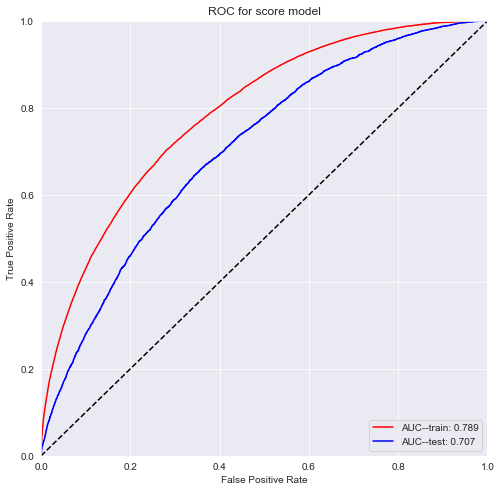

In [207]:
y_train_proba = model_RF.predict_proba(x_train)
y_test_proba = model_RF.predict_proba(x_test)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_proba[:,1])
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba[:,1])
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)
print('AUC--train: %.3f' %roc_auc_train)
print('AUC--test: %.3f' %roc_auc_test)
#plot ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr_train, tpr_train,label='AUC--train: %.3f' %roc_auc_train, color='r')
plt.plot(fpr_test, tpr_test,label='AUC--test: %.3f' %roc_auc_test, color='b')
plt.plot([0,1],[0,1],'k--')#k: black
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Random Forest model')
plt.legend(loc='lower right')

In [215]:
model_RF.feature_importances_

array([0.00885038, 0.00055274, 0.00935374, 0.00046127, 0.00110719,
       0.01903993, 0.00731278, 0.0089484 , 0.01484505, 0.00365534,
       0.07905314, 0.0006329 , 0.        , 0.01935483, 0.00055633,
       0.00230777, 0.03055434, 0.00055725, 0.0177701 , 0.01804741,
       0.02019547, 0.01598069, 0.0074922 , 0.00540418, 0.01306396,
       0.10216731, 0.00570083, 0.01319022, 0.00670269, 0.00075595,
       0.00068014, 0.0070229 , 0.0076542 , 0.00053659, 0.00899798,
       0.00670965, 0.00076619, 0.00812022, 0.00644515, 0.0259541 ,
       0.01674141, 0.01549409, 0.00935201, 0.00829467, 0.0095824 ,
       0.00732755, 0.01861937, 0.02292513, 0.00345687, 0.00102851,
       0.        , 0.00056351, 0.        , 0.12618702, 0.01514194,
       0.00106689, 0.01366732, 0.00231942, 0.01226004, 0.02004844,
       0.00017437, 0.0009597 , 0.00545691, 0.00745963, 0.00021555,
       0.00663264, 0.01125766, 0.00174974, 0.02019183, 0.00234856,
       0.00284705, 0.00367037, 0.01114956, 0.00155521, 0.00878

In [219]:
df[feat].columns

Index(['mosinrcntrevtlop', 'purpose_other', 'emplength', 'numtl30dpd',
       'initialliststatus_f', 'installment', 'addrstate_freq',
       'numrevtlbalgt0', 'revolbal', 'delinq2yrs', 'grade', 'purpose_vacation',
       'purpose_educational', 'mosinoldrevtlop', 'purpose_car',
       'verificationstatus_Not Verified', 'dti', 'accnowdelinq',
       'totalbclimit', 'annualinc', 'ficorangehigh', 'earliestcrline_month',
       'pcttlnvrdlq', 'percentbcgt75', 'mosinoldilacct', 'subgrade',
       'totcollamt', 'mthssincerecentbc', 'mthssincelastmajorderog',
       'homeownership_OWN', 'purpose_debt_consolidation', 'openacc', 'numsats',
       'purpose_major_purchase', 'numactvrevtl', 'mthssincelastdelinq',
       'purpose_credit_card', 'numiltl', 'numactvbctl', 'tothicredlim',
       'totalrevhilim', 'numtloppast12m', 'totalacc', 'mortacc', 'mosinrcnttl',
       'inqlast6mths', 'totcurbal', 'avgcurbal', 'homeownership_RENT',
       'chargeoffwithin12mths', 'purpose_wedding', 'purpose_home_im

In [221]:
feature_importances_ = [round(x,4) for x in model_RF.feature_importances_]
feature_importances_ = pd.Series(feature_importances_, index=df[feat].columns)
feature_importances_ = feature_importances_.sort_values(ascending=True)
feature_importances_

homeownership_ANY                       0.0000
purpose_educational                     0.0000
purpose_wedding                         0.0000
verificationstatusjoint_Not Verified    0.0002
purpose_renewable_energy                0.0002
numtl120dpd2m                           0.0002
numtl30dpd                              0.0005
purpose_major_purchase                  0.0005
purpose_car                             0.0006
purpose_vacation                        0.0006
purpose_house                           0.0006
purpose_home_improvement                0.0006
verificationstatus_Source Verified      0.0006
purpose_other                           0.0006
accnowdelinq                            0.0006
purpose_moving                          0.0007
purpose_medical                         0.0007
purpose_debt_consolidation              0.0007
purpose_credit_card                     0.0008
homeownership_OWN                       0.0008
chargeoffwithin12mths                   0.0010
purpose_small

Text(0, 0.5, 'Features')

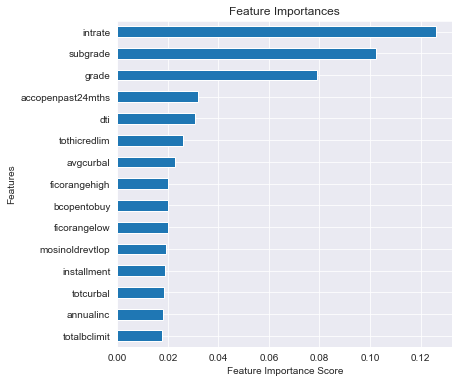

In [222]:
feature_importances_[-15:].plot(kind='barh',title='Feature Importances', figsize=(6, 6))
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')

In [214]:
import pickle

with open('model_RF.pkl', 'wb') as outfile:
    pickle.dump(model_RF, outfile)

## XGBoost Modeling 

In [209]:
model_xgb = xgb.XGBClassifier(objective='binary:logistic',booster='gbtree',n_estimators=400, learning_rate= 0.04, 
                              max_depth=6, min_child_weight=75, gamma=0.8, seed=1234,
                              subsample=0.78, colsample_bytree=0.67)

In [210]:
model_xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.67, gamma=0.8, learning_rate=0.04,
       max_delta_step=0, max_depth=6, min_child_weight=75, missing=None,
       n_estimators=400, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1234, silent=True,
       subsample=0.78)

AUC--train: 0.749
AUC--test: 0.719


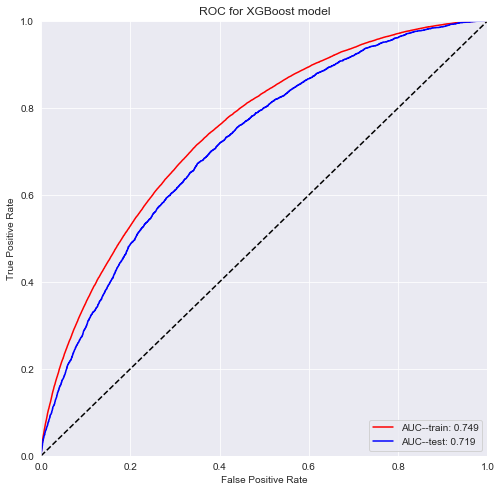

In [212]:
y_train_proba = model_xgb.predict_proba(x_train)
y_test_proba = model_xgb.predict_proba(x_test)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_proba[:,1])
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba[:,1])
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)
print('AUC--train: %.3f' %roc_auc_train)
print('AUC--test: %.3f' %roc_auc_test)
#plot ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr_train, tpr_train,label='AUC--train: %.3f' %roc_auc_train, color='r')
plt.plot(fpr_test, tpr_test,label='AUC--test: %.3f' %roc_auc_test, color='b')
plt.plot([0,1],[0,1],'k--')#k: black
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for XGBoost model')
plt.legend(loc='lower right')

In [ ]:
# imputing missing values does not help improve performance